In [2]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set()

#Importing required modules
from sklearn.cluster import KMeans

df = pd.read_csv('pizza.csv')
rando = 120

As a single shop may occupy >= 1 row in the dataset due to having multiple line items in their menu, we will first drop duplicate addresses to find the unique number of shops

In [3]:
df_clean = df.drop_duplicates(subset=['address'])

In [4]:
df_clean.shape

(2278, 19)

While the original dataset had 10,000 lines of data, there are 2285 unique locations for pizza restaurants as shown above.

Next, we will represent all the pizza joints located in the US by plotting them according to its longitude and latitude.

<function matplotlib.pyplot.show(close=None, block=None)>

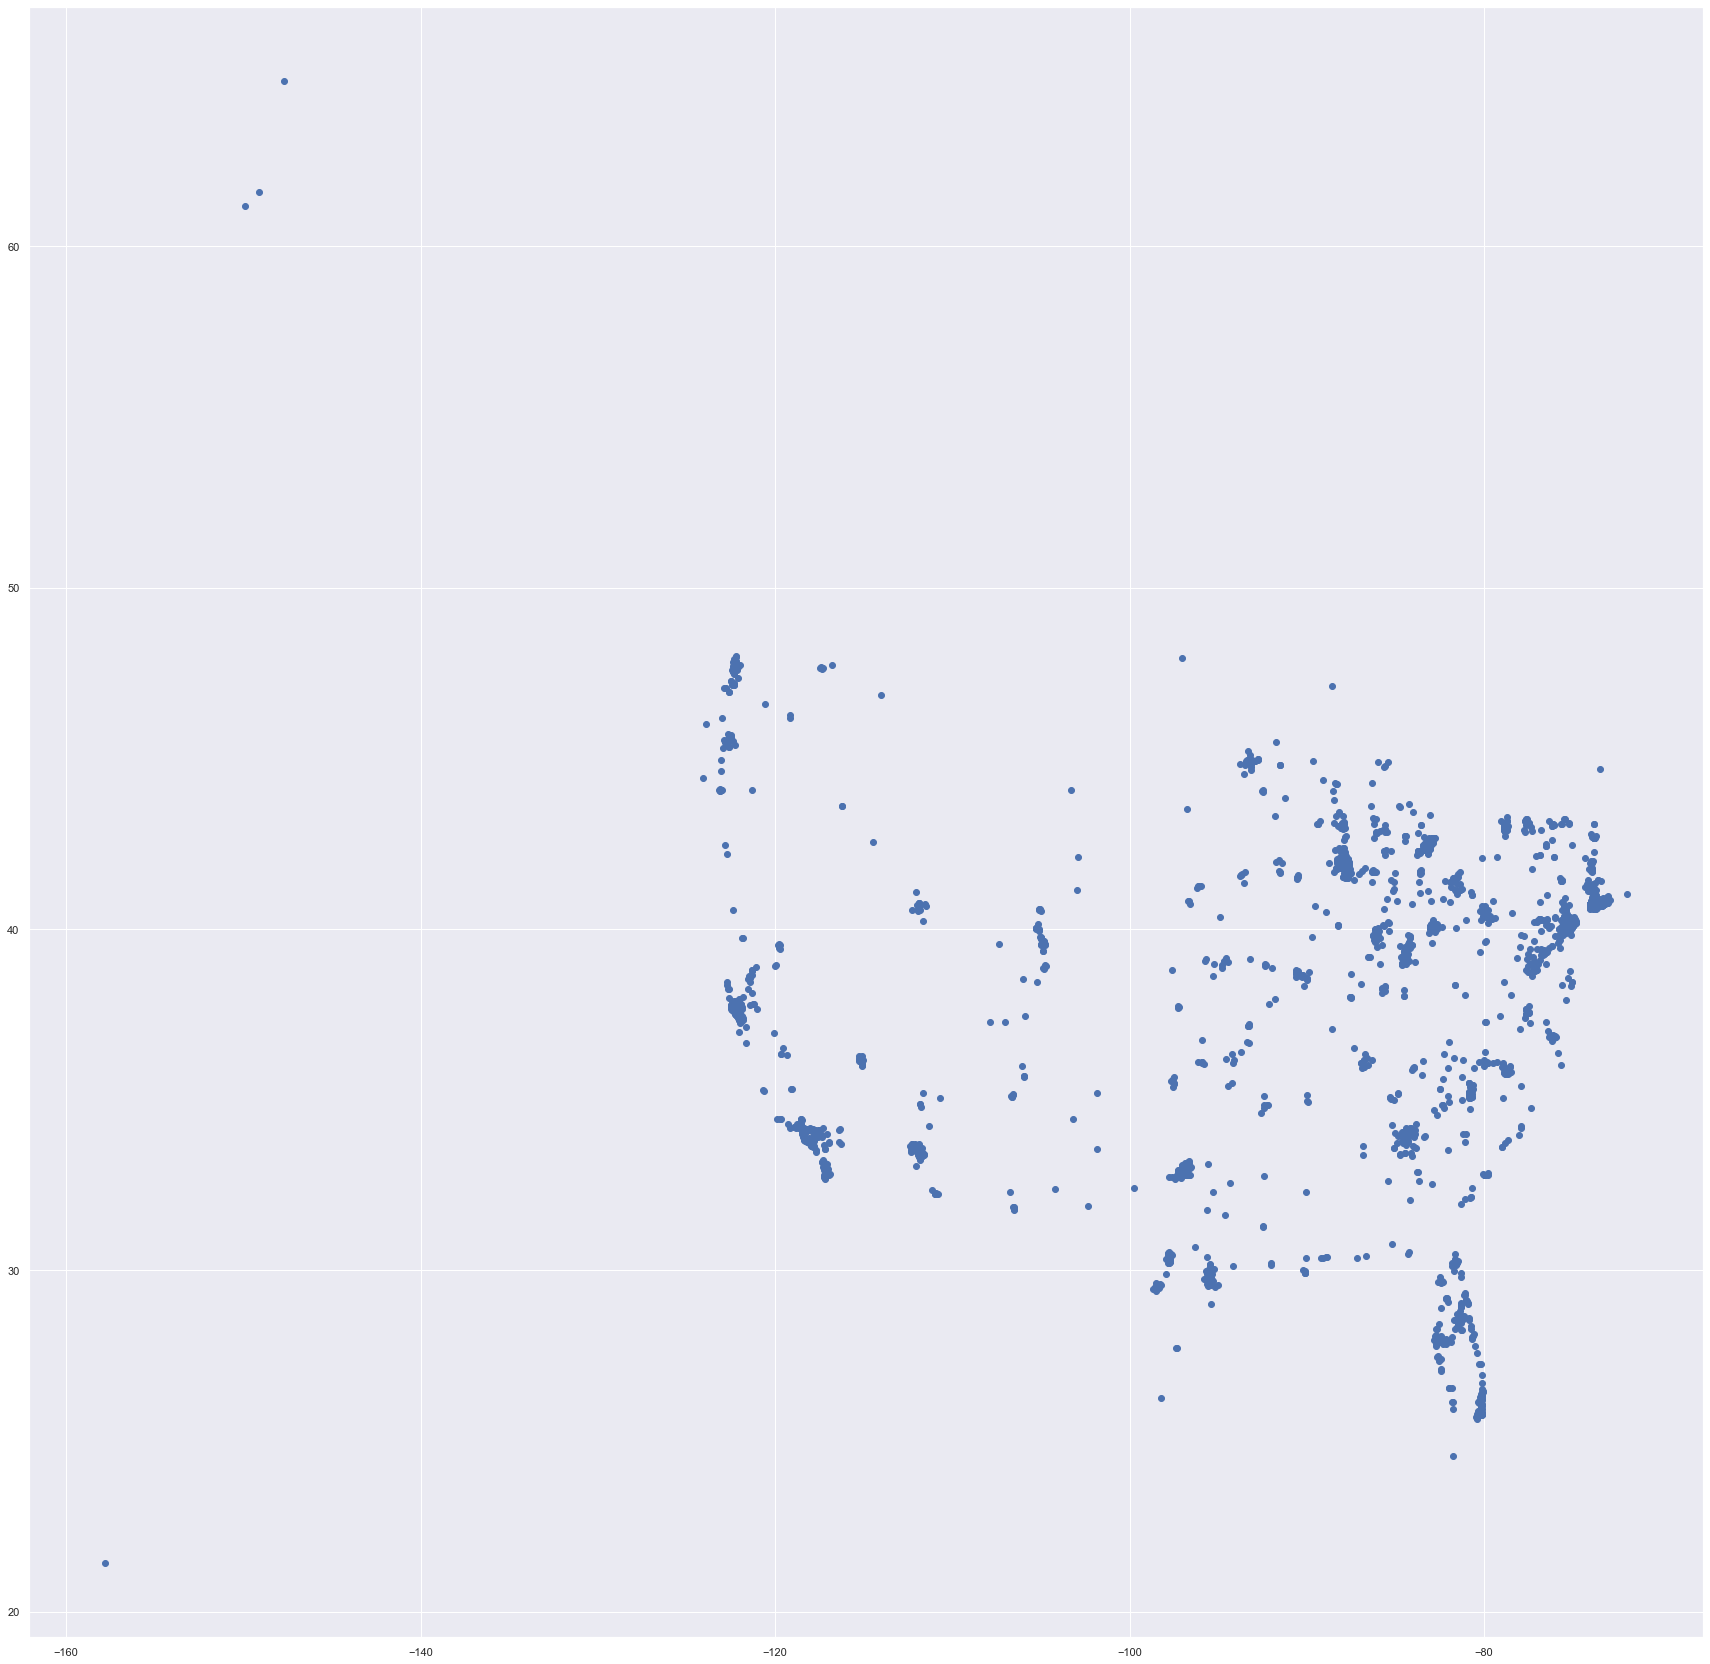

In [5]:
f, axes = plt.subplots(figsize=(30,30))

long = df_clean["longitude"]
lat = df_clean["latitude"]
plt.scatter(long,lat)
plt.show

Noting that Alaska region contains 3 pizza joints, and Hawaii has 1 pizza joint, we will remove them from our dataset as we are not considering opening pizza joints in Alaksa nor Hawaii.

This will be done by filtering out pizza joints that has coordinates (longitude and latitude) outside of the US mainland.

<function matplotlib.pyplot.show(close=None, block=None)>

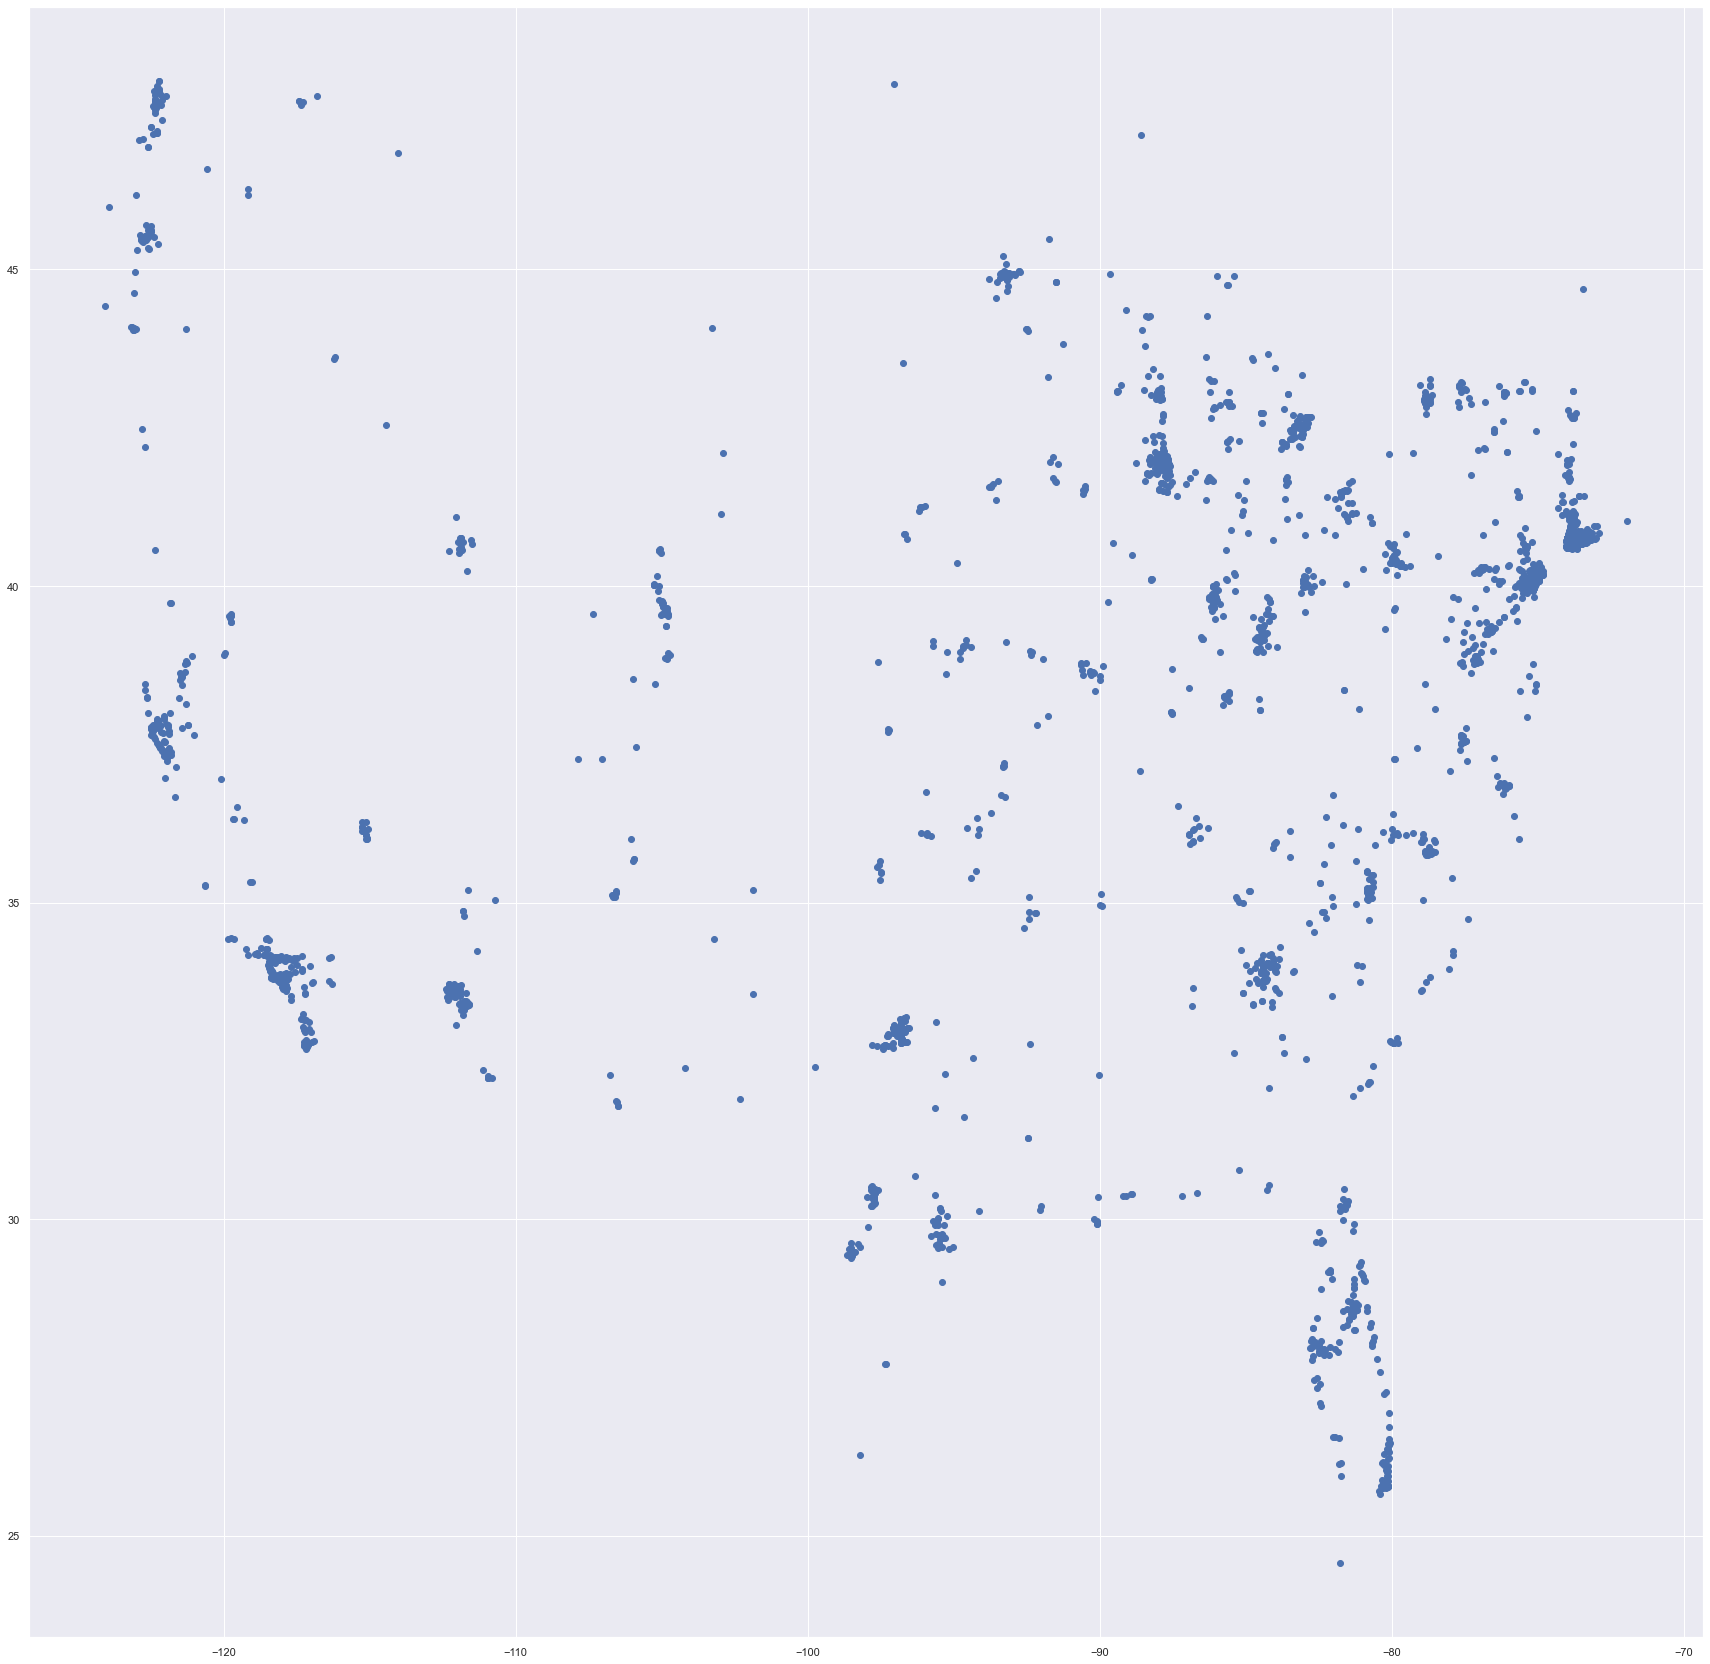

In [6]:
f, axes = plt.subplots(figsize=(30,30))

cleaned = df_clean[(df_clean['latitude'] < 50) & (df_clean['longitude'] > -140)]
long_clean = cleaned["longitude"]
lat_clean = cleaned["latitude"]

plt.scatter(long_clean,lat_clean)
plt.show

## Perform k-means clustering

Now we will apply k-means clustering on the dataset. We will set it at a default of **10 clusters** for now. We will find the optimal number of clusters later on.

We will use inertia/sum of square error as the cost function for k-means. It measures the Euclidian distance between a centroid and a datapoint, squaring it. It will then assigning the datapoint to a centroid with the lowest inertia. This is done for all our datapoints. 

Subsequently, the centroids will be shifted to reduce total inertia summed up across all assigned datapoints before performing the previous step again. This will run recursively until every centroid barely moves, indicating the optimisation of cost function.

## Example

We will assign the first 50 datapoints to their cluster as shown below in a list. Do note that the assigned cluster is the final cluster assigned after multiple iterations of the process. 

In [7]:
kmeans = KMeans(n_clusters = 10, random_state = rando)
cluster = pd.DataFrame(cleaned[["longitude","latitude"]])
# cluster.shape
label = kmeans.fit_predict(cluster)
print(label[:50])

[4 1 9 9 2 7 8 9 1 6 0 2 4 8 2 8 9 7 2 4 1 2 9 3 2 2 1 6 2 2 1 9 1 4 1 0 9
 4 4 1 3 8 0 2 4 2 2 2 2 1]


## Showing all points of cluster label == 0

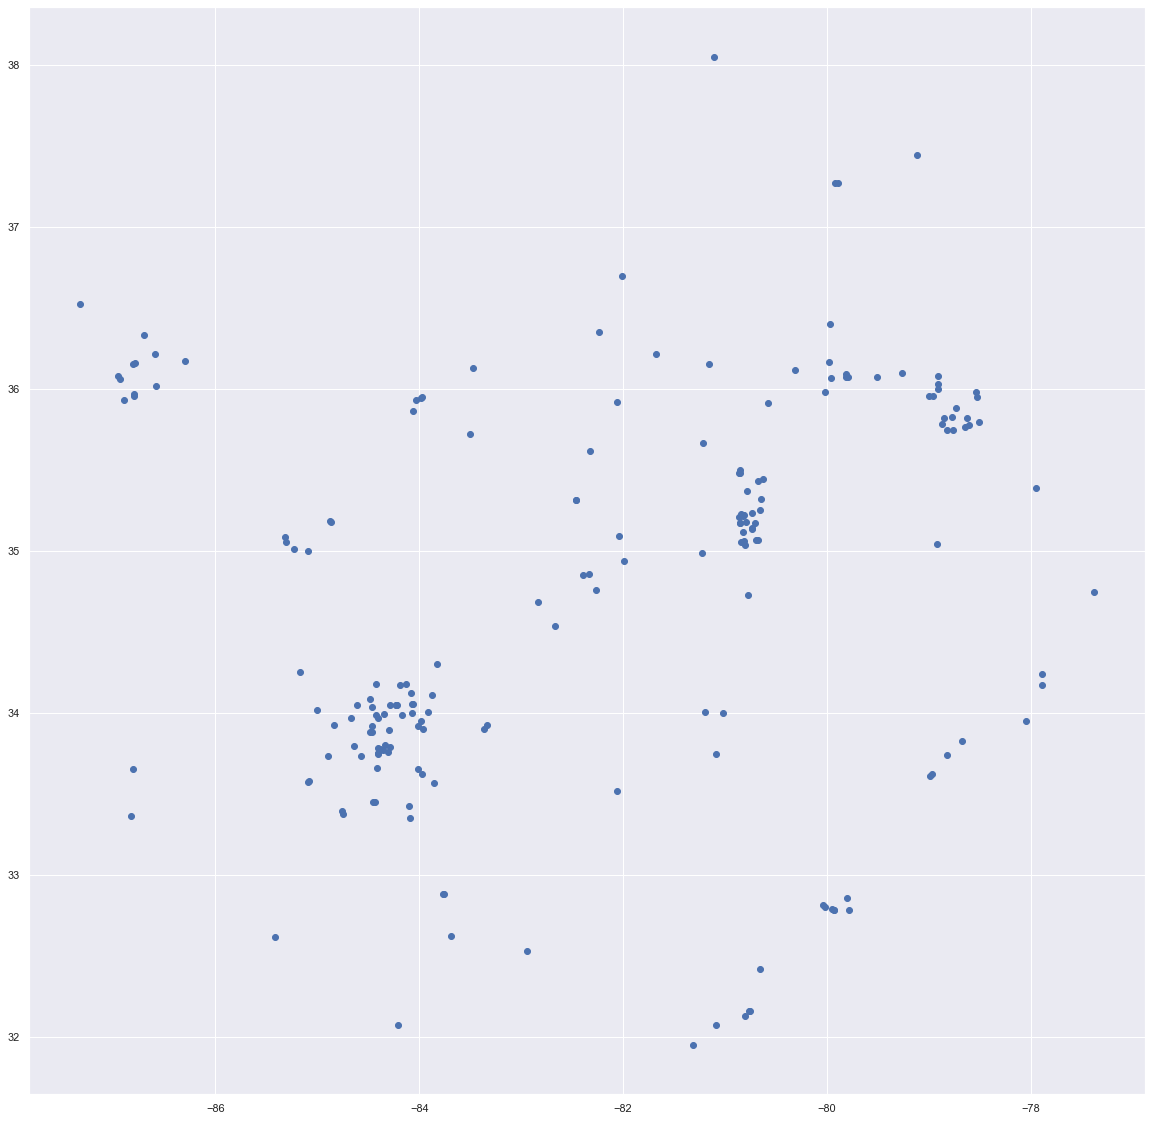

In [8]:
f, axes = plt.subplots(figsize=(20,20))
#filter rows of original data
filtered_label0 = cleaned[label == 0]
#print(filtered_label0)
#plotting the results
plt.scatter(filtered_label0["longitude"] , filtered_label0["latitude"])
plt.show()

## Given 10 clusters, this is how the datapoints will be categorised

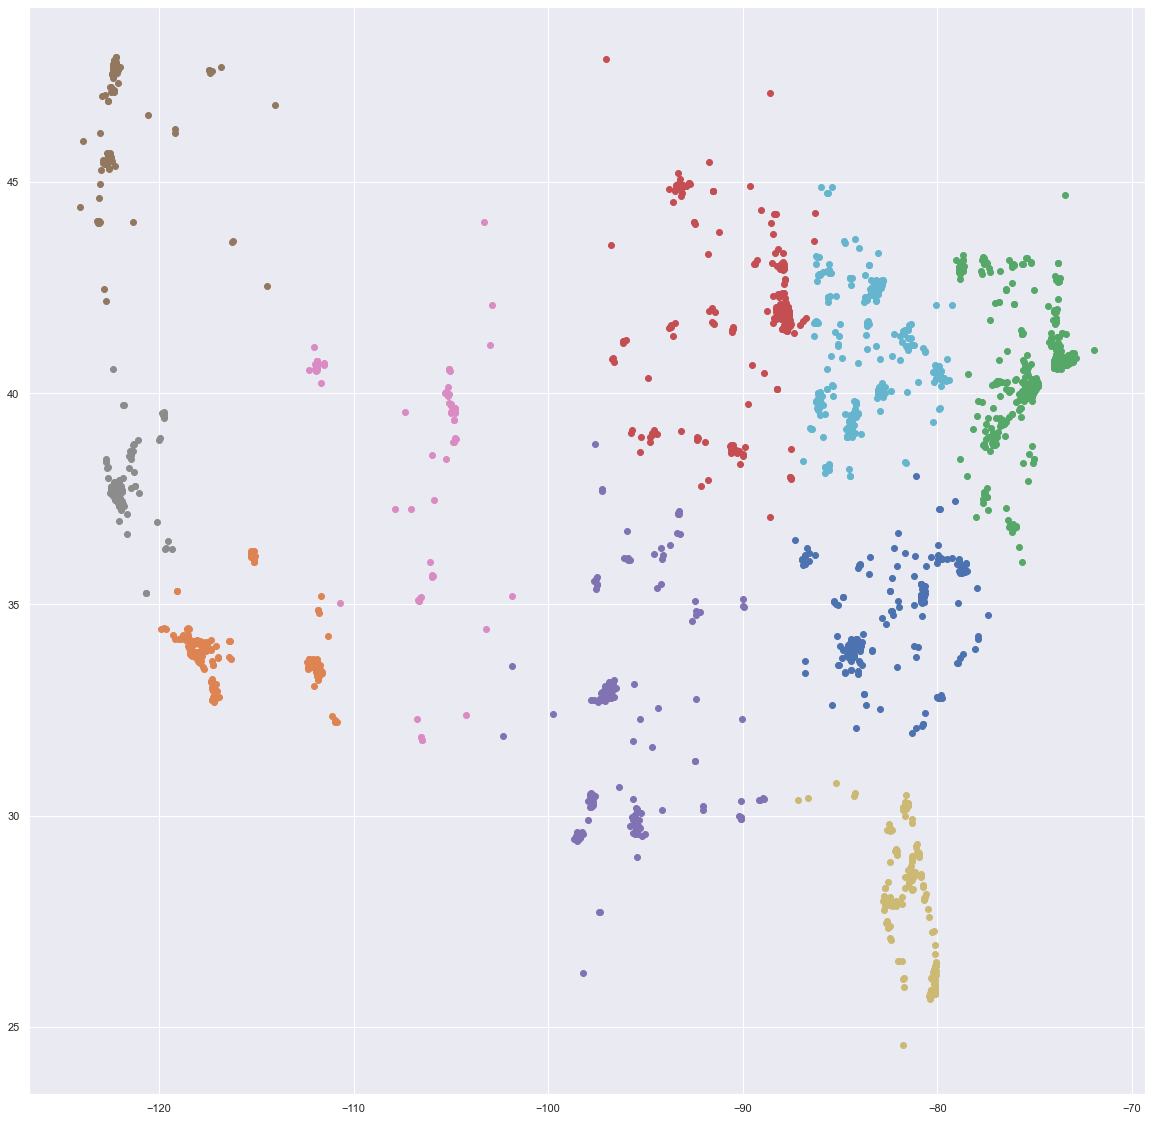

In [9]:
labels = np.unique(label)
f, axes = plt.subplots(figsize=(20,20))

for l in labels:
    filtered_label = cleaned[label == l]
    plt.scatter(filtered_label["longitude"] , filtered_label["latitude"])

## To find the optimal number of clusters (n), we will have to observe the 'elbow point' of Sum of Squared Error (SSE) against n. To plot this graph, we will calculate the SSE for every n up to 20.

In [10]:
def cal_inertia(n):
    cluster = pd.DataFrame(cleaned[["longitude","latitude"]])
    kmeans = KMeans(n_clusters = n, random_state = rando).fit(cluster)
    kmeans.fit(cluster)

    return kmeans.inertia_


In [11]:
lst = []
max = 20
for i in range(2,max):
    lst.append(cal_inertia(i))

x_axis = list(range(2,max))
y_axis = lst

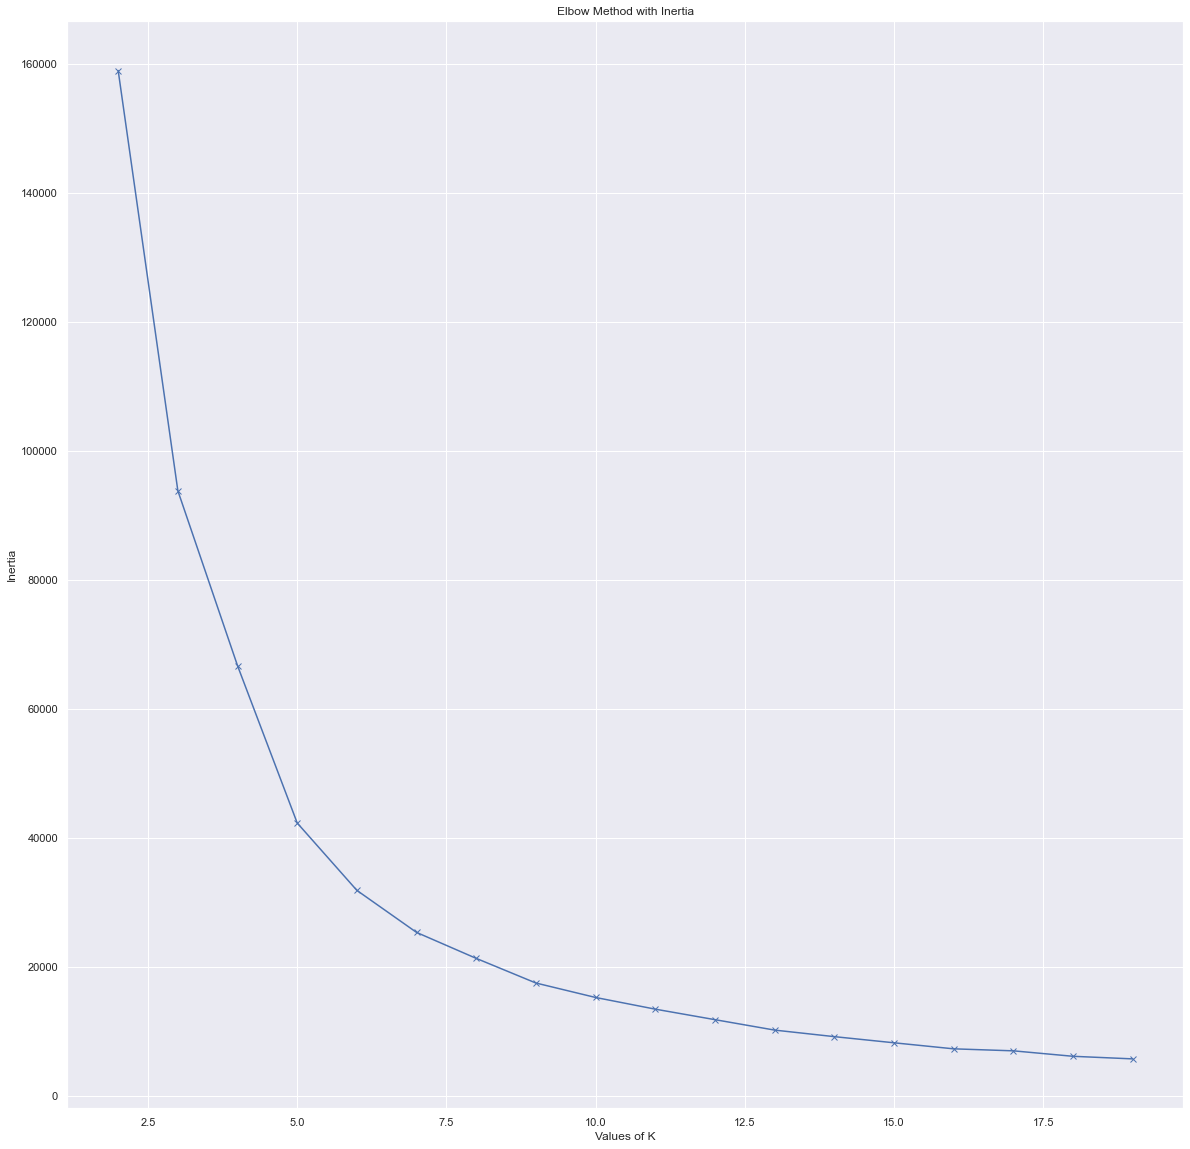

In [12]:
f, axes = plt.subplots(figsize=(20,20))
plt.plot(x_axis, y_axis, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('Elbow Method with Inertia')
plt.show()

In [13]:
from scipy.spatial.distance import cdist

distortions = []
mapping1 = {}
K = range(1, 20)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, random_state = rando).fit(cluster)
    kmeanModel.fit(cluster)
  
    distortions.append(sum(np.min(cdist(cluster, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / cluster.shape[0])
  
    mapping1[k] = sum(np.min(cdist(cluster, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / cluster.shape[0]

C:\Users\melvi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\melvi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


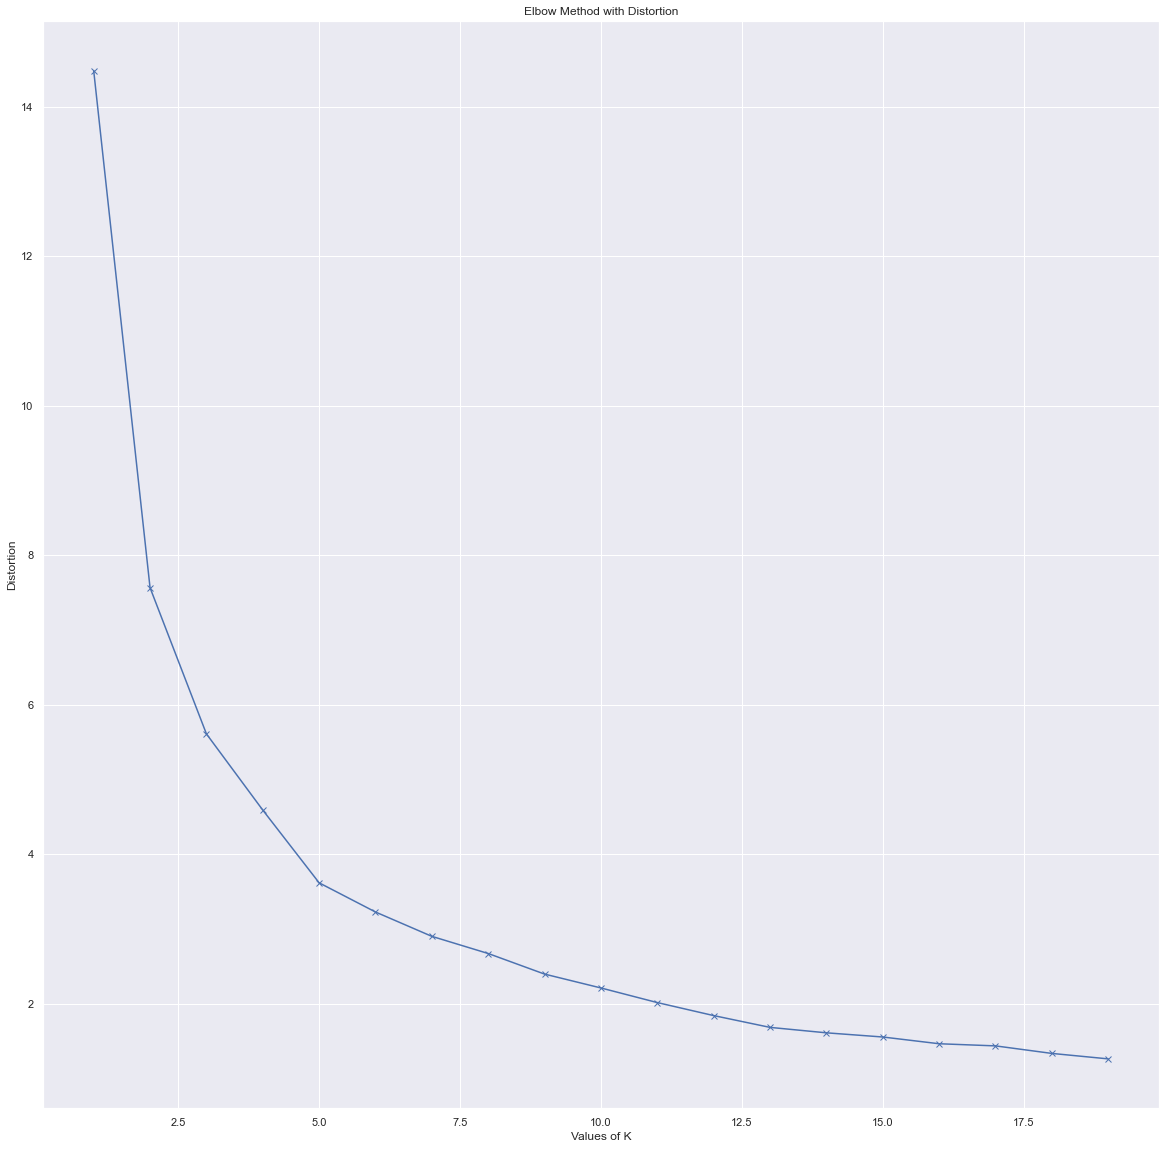

In [14]:
f, axes = plt.subplots(figsize=(20,20))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method with Distortion')
plt.show()

## By observation, n = 7 produces the best results as Sum of Squared Error (SSE) decreases in a linear fashion thereafter

### Now let us find out what are the range of prices set by restaurants in various clusters. This can be achieved by representing the median prices of each pizza joint separated by cluster

In [15]:
grp = cleaned.groupby('address')
total = 0
median_price = []
for add in cleaned.address.unique():
    median_price.append(grp.get_group(add)["menus.amountMax"].median())

cleaned['Median_Price'] = median_price
cleaned['Cluster'] = label

C:\Users\melvi\AppData\Local\Temp\ipykernel_808\4065577505.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['Median_Price'] = median_price
C:\Users\melvi\AppData\Local\Temp\ipykernel_808\4065577505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['Cluster'] = label


## Let's plot the pizza joints clustered by n=7 again

C:\Users\melvi\AppData\Local\Temp\ipykernel_808\4193047421.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['Cluster'] = label


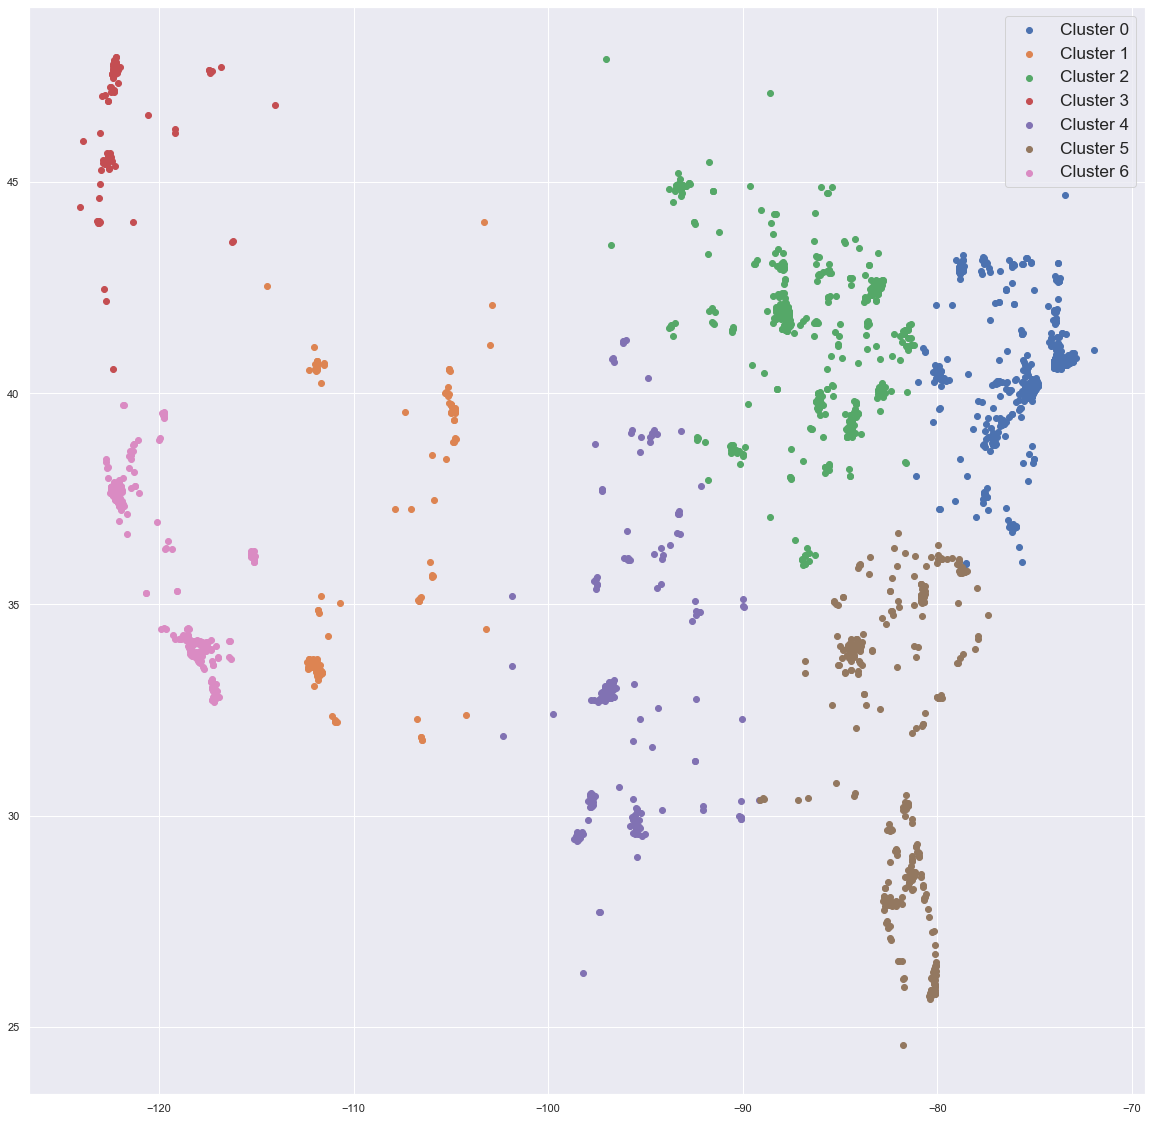

In [16]:
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets)

kmeans = KMeans(n_clusters = 7, random_state = rando)
cluster = pd.DataFrame(cleaned[["longitude","latitude"]])
label = kmeans.fit_predict(cluster)
labels = np.unique(label)
cleaned['Cluster'] = label
f, axes = plt.subplots(figsize=(20,20))

for l in labels:
    filtered_label = cleaned[label == l]
    plt.scatter(filtered_label["longitude"] , filtered_label["latitude"], label = "Cluster " + str(l))

plt.legend(fontsize = 'x-large')



## Now we will plot out the median prices of each unique pizza joint grouped by their respective clusters

<AxesSubplot:title={'center':'Median_Price'}, xlabel='Median Price', ylabel='Cluster'>

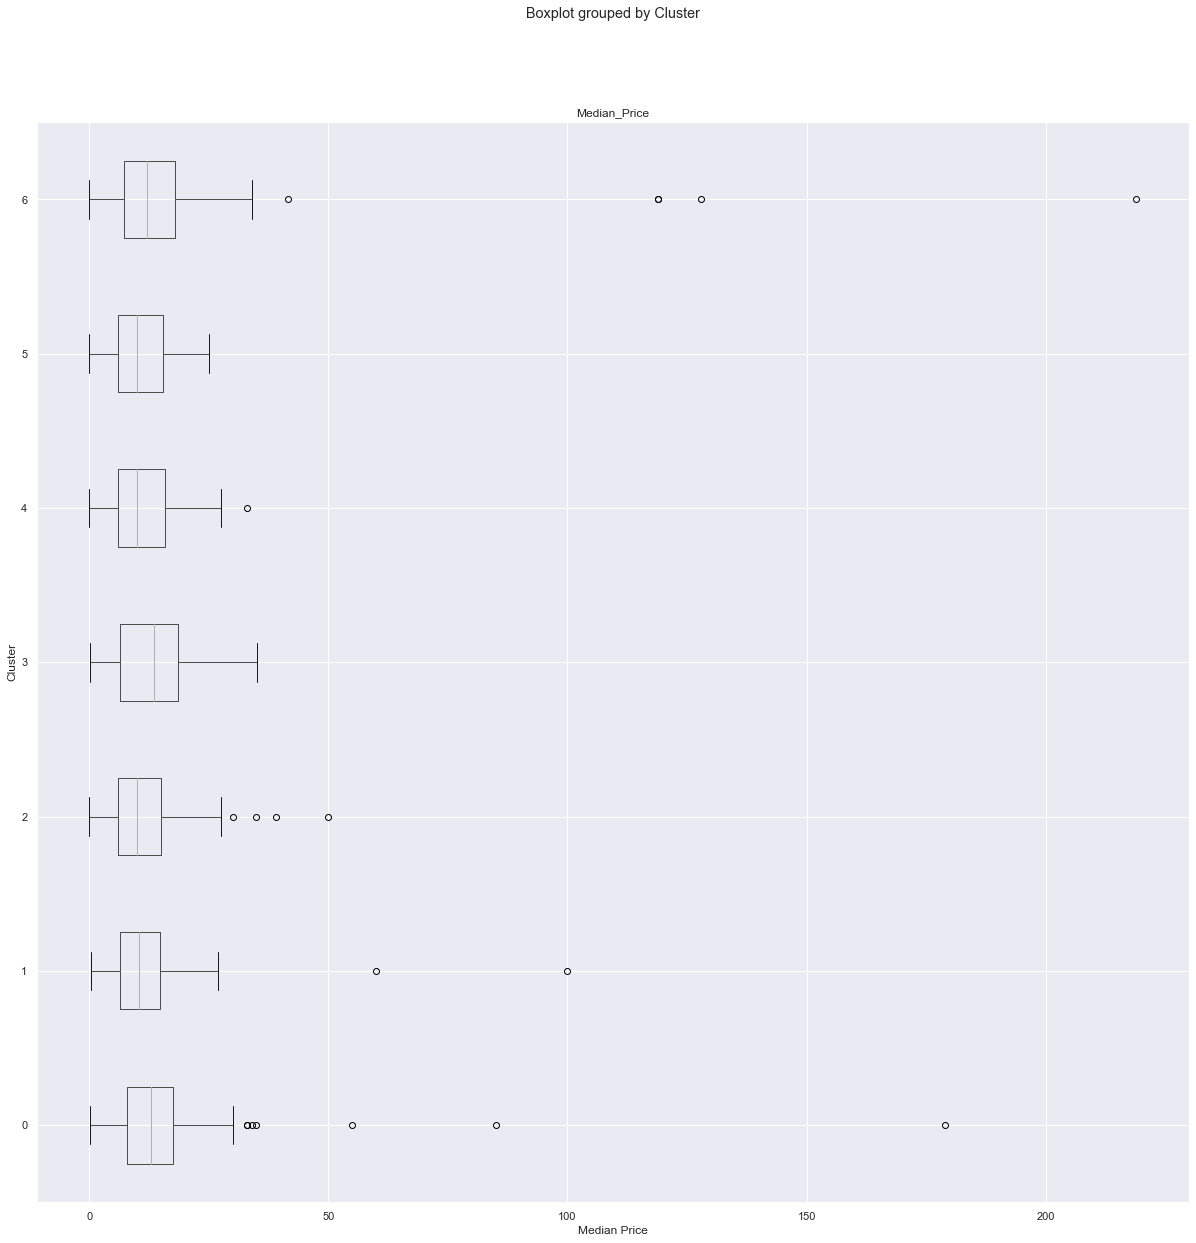

In [17]:
f, axes = plt.subplots(figsize=(20,20))
bplot = cleaned.boxplot(column = ["Median_Price"], by = 'Cluster', ax = axes, vert = False)
bplot.set_xlabel('Median Price')
bplot.set_ylabel('Cluster')
bplot

## Now we will create 7 dataframes accordingly to analyse each cluster in-depth, as well as to remove outliers

In [18]:
def create_df(cluster_num):
    return pd.DataFrame(cleaned[cleaned["Cluster"] == cluster_num])
lst_of_frames = []
for i in range(7):
    lst_of_frames.append(create_df(i))


In [19]:
def remove_outlier(df, var):
    Q1_var = df[var].quantile(0.25)
    Q3_var = df[var].quantile(0.75)
    IQR_var = Q3_var - Q1_var
    orig_size = len(df)
    df = df[(df[var] > (Q1_var - 1.5 * IQR_var)) & (df[var] < (Q3_var + 1.5 * IQR_var))]
    print("Outliers removed in: ", orig_size - len(df)) 
    
    return (df)

In [20]:
for cluster in range(7):
    lst_of_frames[cluster] = remove_outlier(lst_of_frames[cluster], "Median_Price")
    print(len(lst_of_frames[cluster]))


Outliers removed in:  7
706
Outliers removed in:  2
143
Outliers removed in:  4
501
Outliers removed in:  0
92
Outliers removed in:  1
205
Outliers removed in:  0
340
Outliers removed in:  5
268


## Merge the dataframes back together again after cleaning

In [21]:
result = pd.concat(lst_of_frames)

<AxesSubplot:title={'center':'Median_Price'}, xlabel='Median Price', ylabel='Cluster'>

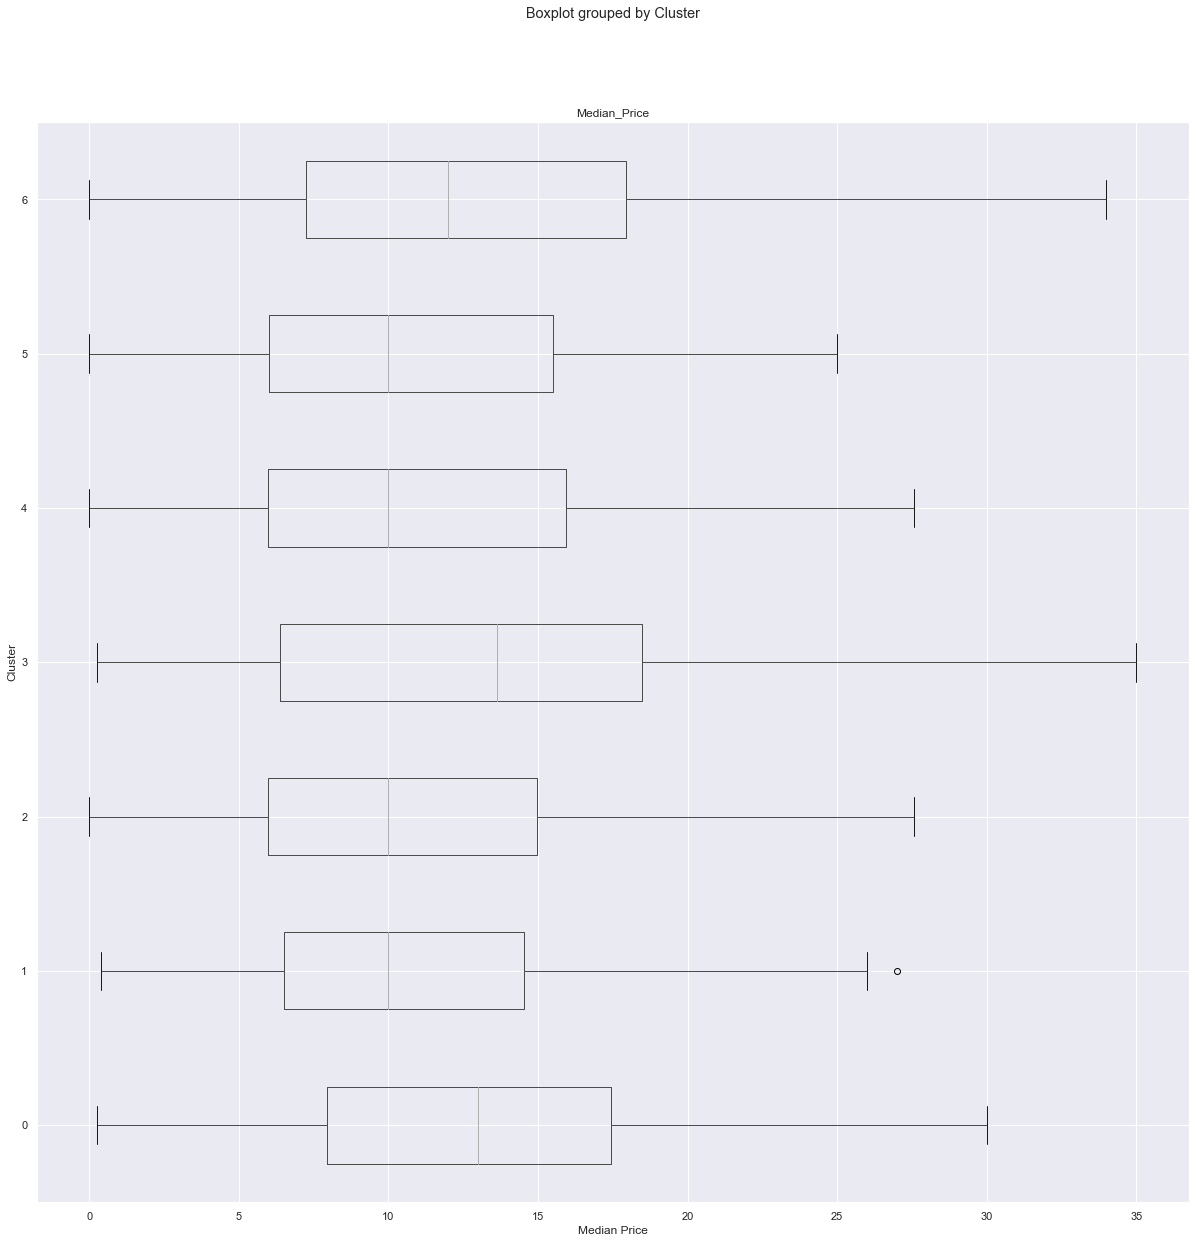

In [22]:
f, axes = plt.subplots(figsize=(20,20))
bplot = result.boxplot(column = ["Median_Price"], by = 'Cluster', ax = axes, vert = False)
bplot.set_xlabel('Median Price')
bplot.set_ylabel('Cluster')
bplot

## Now that we know how to price our pizzas, we need to find out where is a good location to place it. We will determine this by the populations of the top 300 cities

### We will first generate the centroids of each cluster as shown below

[4 1 2 ... 0 0 6]


C:\Users\melvi\AppData\Local\Temp\ipykernel_808\61533246.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['Cluster'] = label


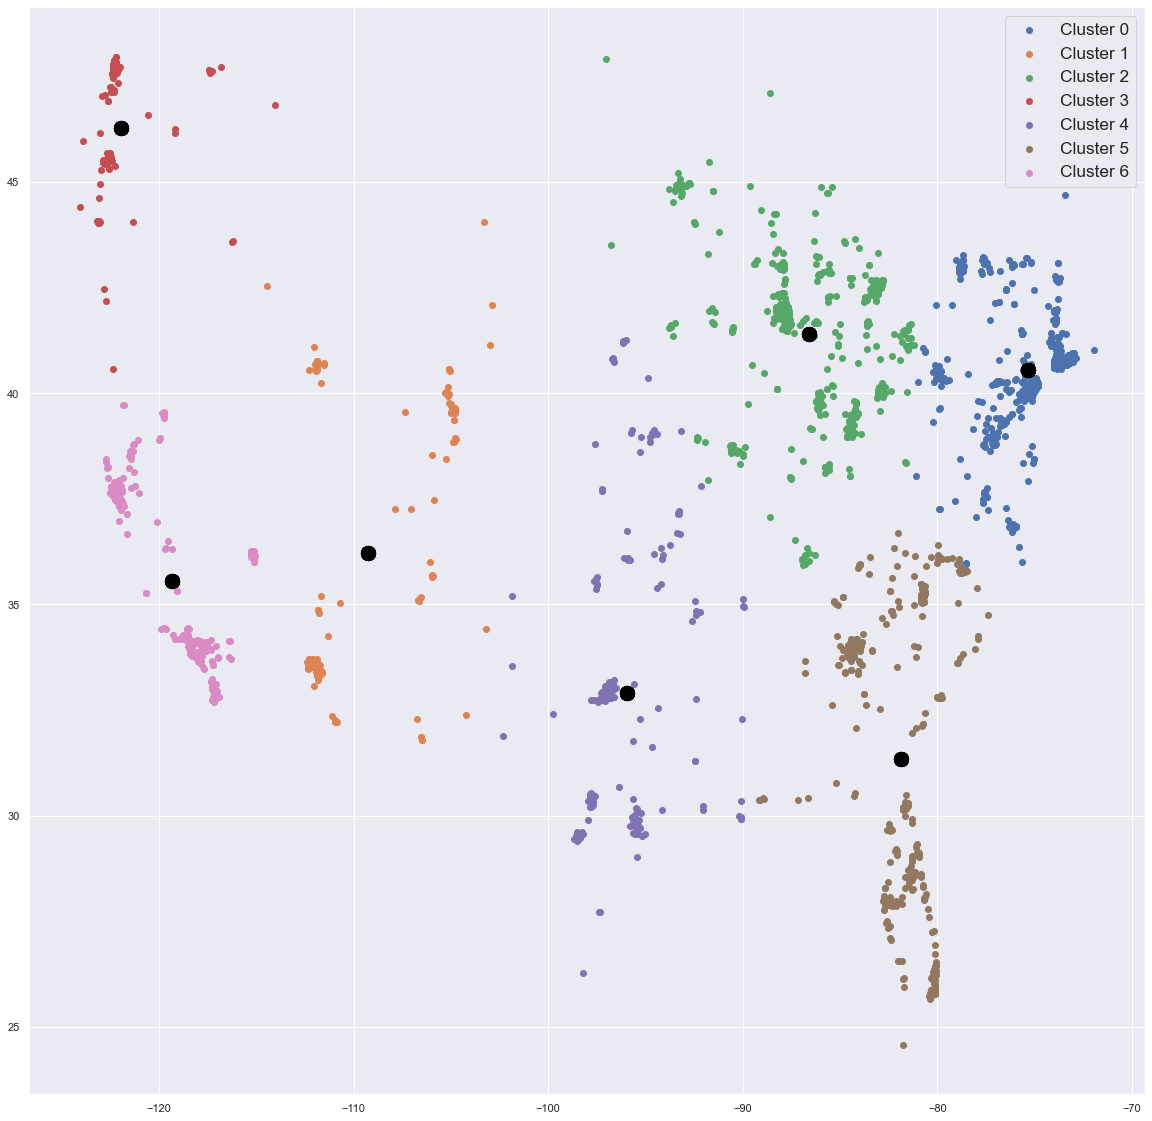

In [23]:
kmeans = KMeans(n_clusters = 7, random_state = rando)
cluster = pd.DataFrame(cleaned[["longitude","latitude"]])
#print(cluster)
label = kmeans.fit_predict(cluster)
print((label))
labels = np.unique(label)
cleaned['Cluster'] = label
f, axes = plt.subplots(figsize=(20,20))

for l in labels:
    filtered_label = cleaned[label == l]
    plt.scatter(filtered_label["longitude"] , filtered_label["latitude"], label = "Cluster " + str(l))
    centroids = kmeans.cluster_centers_
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black')

plt.legend(fontsize = 'x-large')



## Then we will assign each city to a centroid depending on which is the closest

### We will achieve this by calculating the distance between a city and centroid, then assigning the city to its closest centroid by attaching a 'cluster' column to the dataframe

In [24]:
cities = pd.read_csv('Population.csv')
cities.shape

(331, 13)

(329, 13)

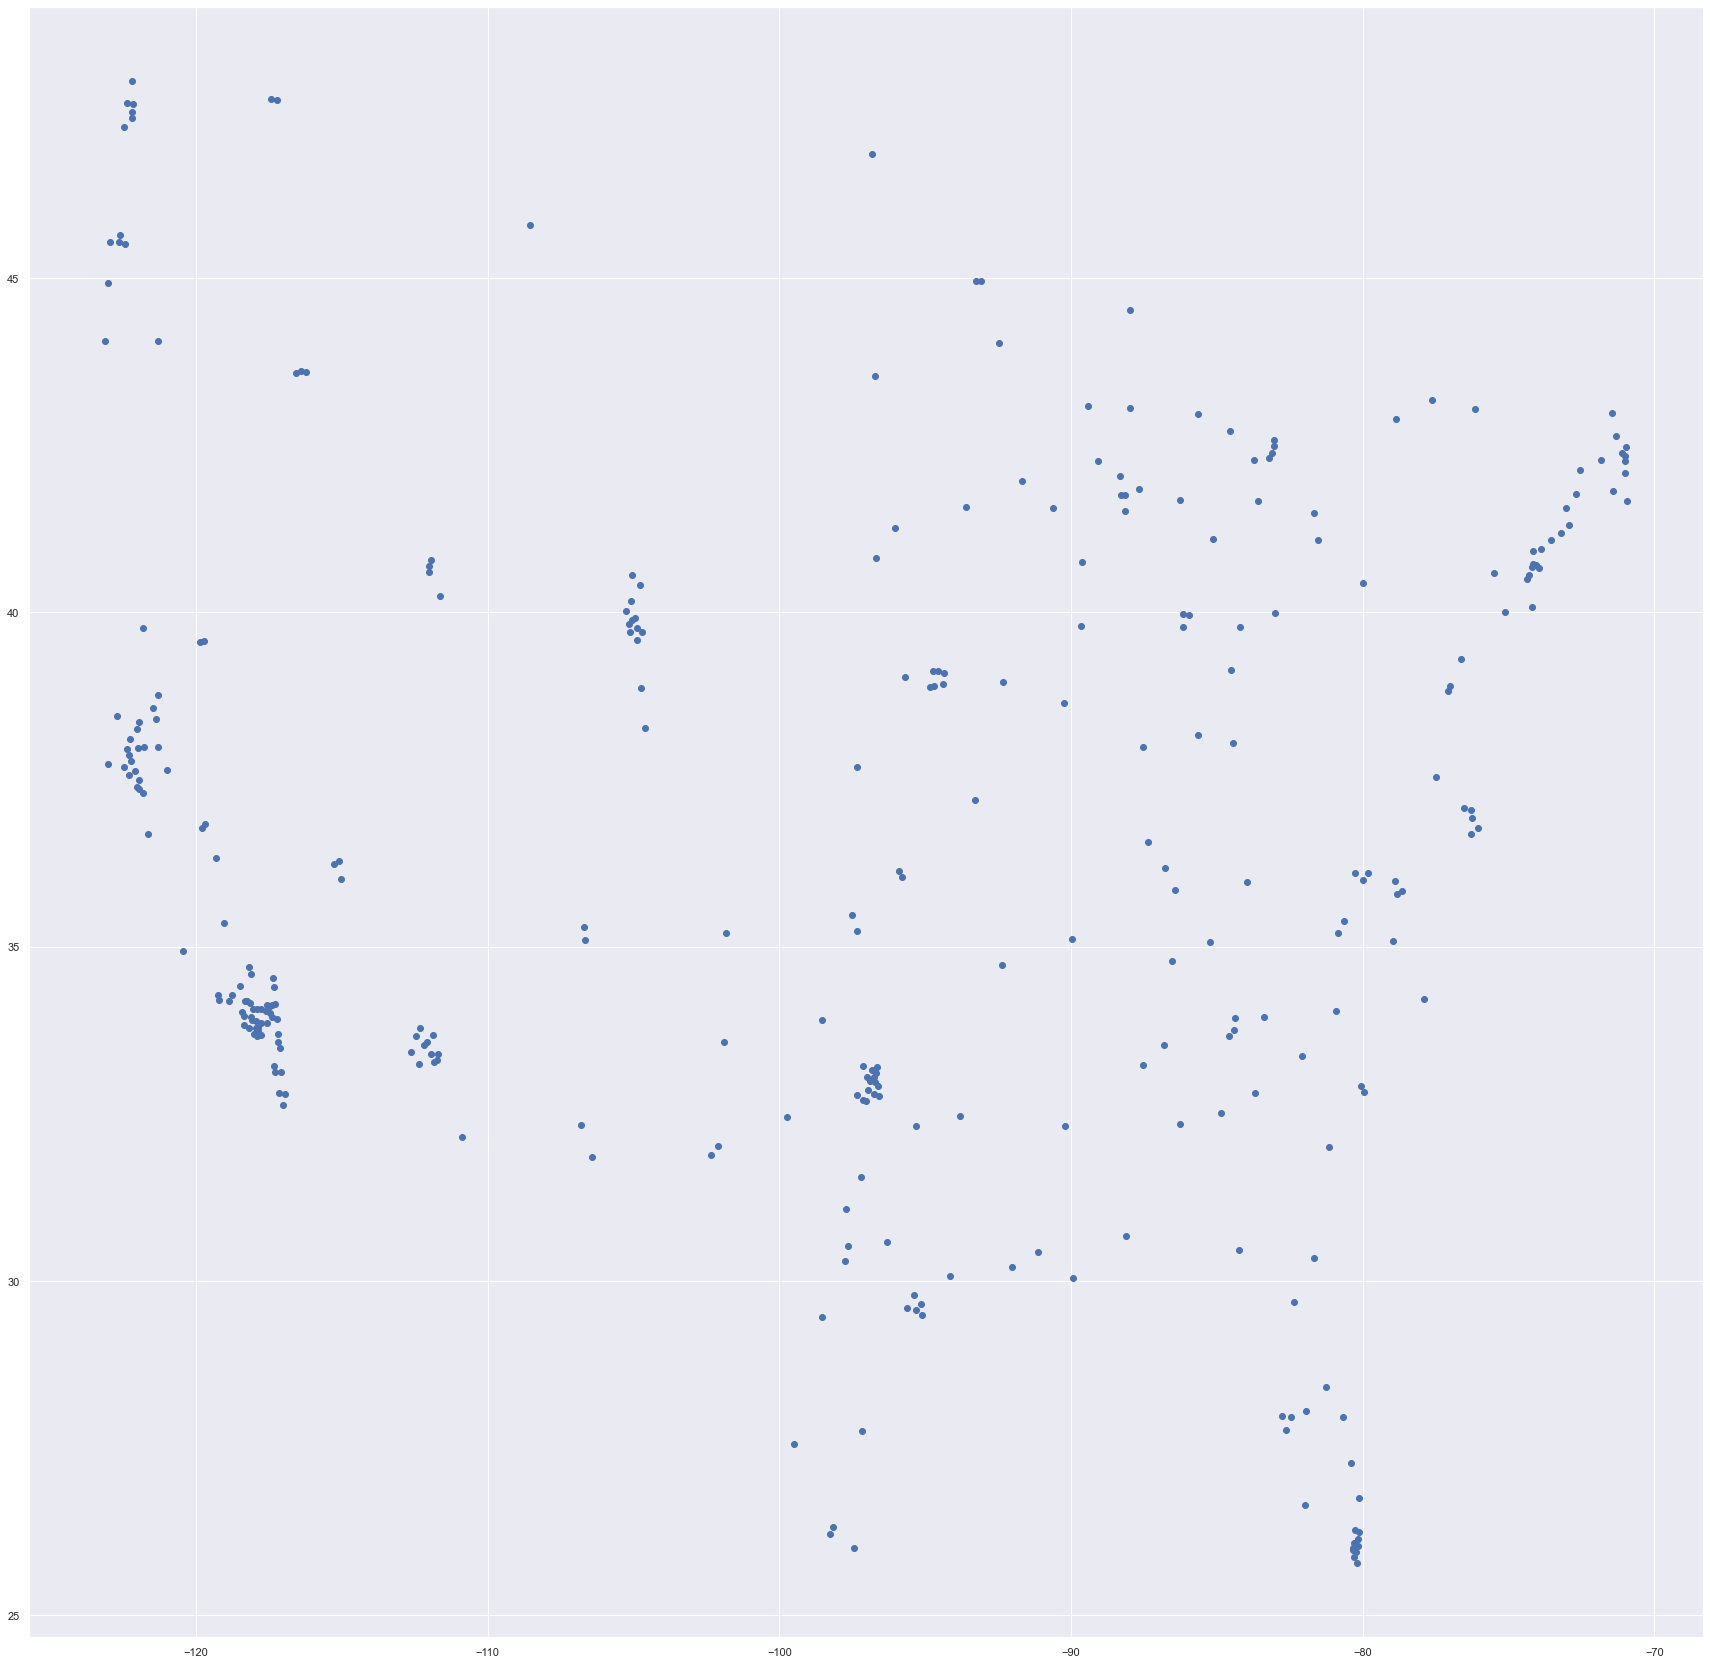

In [25]:
f, axes = plt.subplots(figsize=(30,30))

cities = cities[(cities['Latitude'] < 50) & (cities['Longitude'] > -140)]

long_clean = cities['Longitude']
lat_clean = cities["Latitude"]

plt.scatter(long_clean,lat_clean)
plt.show
cities.shape


In [26]:
centroids = kmeans.cluster_centers_
[print("Cluster " , index , ":" , centroids[index][0] , centroids[index][1]) for index in range(0,7)]

Cluster  0 : -75.34009069021039 40.565674663786815
Cluster  1 : -109.27271676896552 36.211810453517245
Cluster  2 : -86.60081308287128 41.403994850178215
Cluster  3 : -121.94233069673913 46.283697222391304
Cluster  4 : -95.96173641393204 32.910459388446604
Cluster  5 : -81.86479602979412 31.33077280732353
Cluster  6 : -119.33002543076924 35.54758894362637


[None, None, None, None, None, None, None]

In [27]:
test = cities.iloc[0,11:13]
print(test)

Longitude   -73.94
Latitude     40.66
Name: 0, dtype: object


In [28]:
from math import dist

def find_closest_centroid (datapoint):
    distance = []
    for index in range(0,7):
        distance.append(dist((datapoint[0],datapoint[1]),(centroids[index][0],centroids[index][1])))
        #print(distance)
    return (distance.index(min(distance)))
        
#print("Cluster :", find_closest_centroid(cities.iloc[1,11:13]))

In [29]:
print(cities)

     Index         City          State  2021 estimate 2020 census  Change  \
0        1     New York       New York        8467513   8,804,190  −3.82%   
1        2  Los Angeles     California        3849297   3,898,747  −1.27%   
2        3      Chicago       Illinois        2696555   2,746,388  −1.81%   
3        4      Houston          Texas        2288250   2,304,580  −0.71%   
4        5      Phoenix        Arizona        1624569   1,608,139   1.02%   
..     ...          ...            ...            ...         ...     ...   
326    327         Lynn  Massachusetts         100843     101,253  −0.40%   
327    328       Carmel        Indiana         100777      99,757   1.02%   
328    329     Longmont       Colorado         100758      98,885   1.89%   
329    330   Tuscaloosa        Alabama         100618      99,600   1.02%   
330    331      Norwalk     California         100373     102,773  −2.34%   

    2020 land area 2020 land area.1 2020 population density  \
0      300.5

In [30]:
cluster = []
for row in range(len(cities)):
    cluster.append(find_closest_centroid(cities.iloc[row,11:13]))
cities["Cluster"] = cluster

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

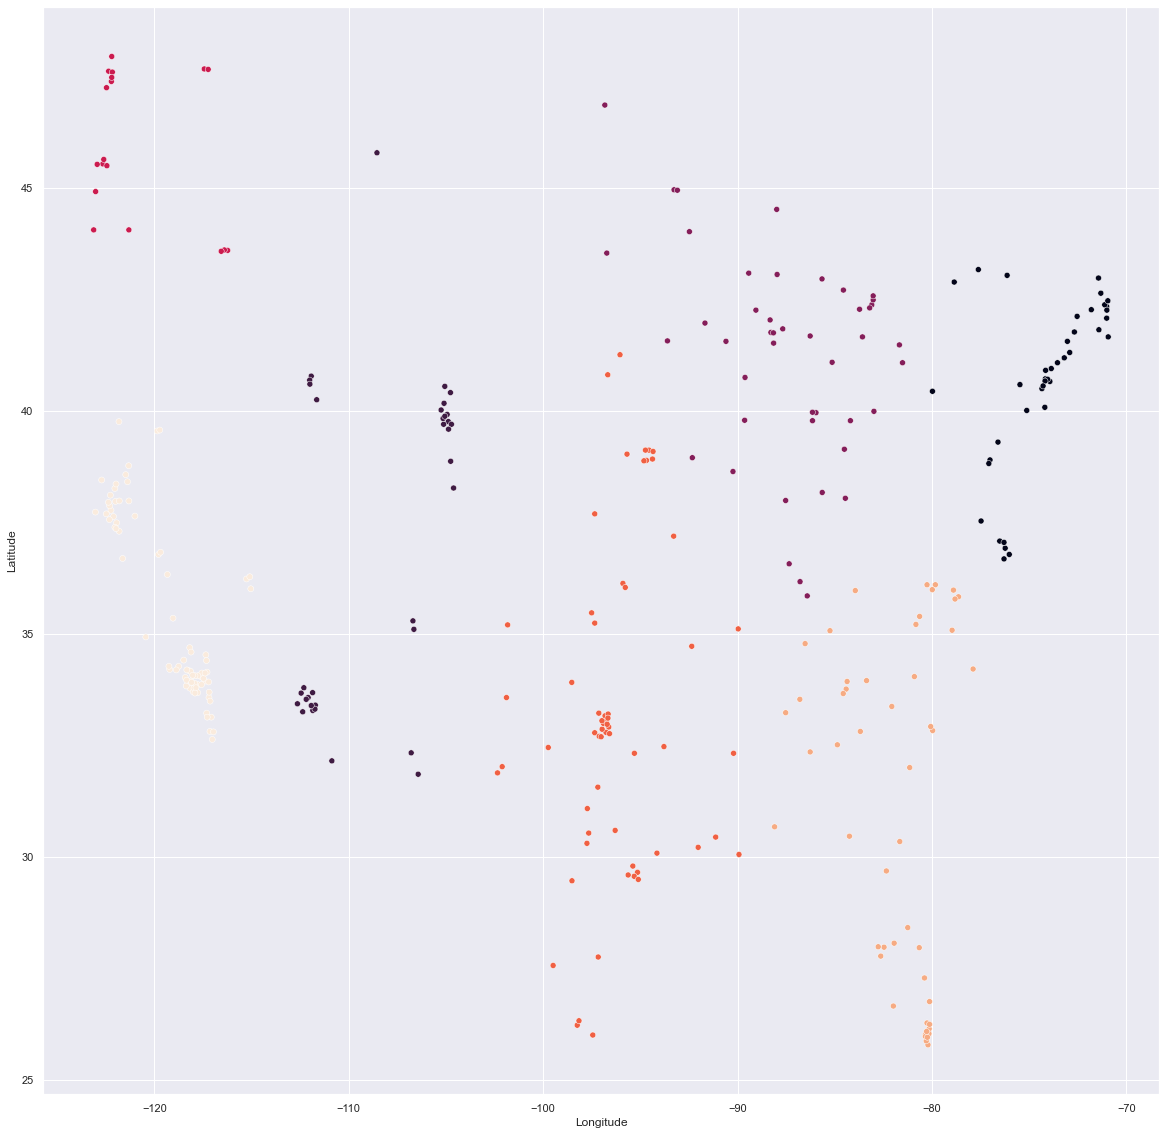

In [31]:
f, axes = plt.subplots(figsize=(20,20))
sb.scatterplot(x=cities['Longitude'], y=cities['Latitude'], c=cities['Cluster'])

In [32]:
##cluster_pop: (population, number of cities)

In [33]:
cluster_pop = [0] * 7
cluster_pop_cities = [0] * 7

for index in range(len(cities)):
    clus = cities.iloc[index,13] 
    cluster_pop[clus] += int(cities.iloc[index,4].replace(",", ""))
    cluster_pop_cities[clus] += 1
print(cluster_pop)
#print(cluster_pop_cities)

[18507548, 9363478, 13915538, 3763180, 18591626, 10999037, 21743784]


<AxesSubplot:>

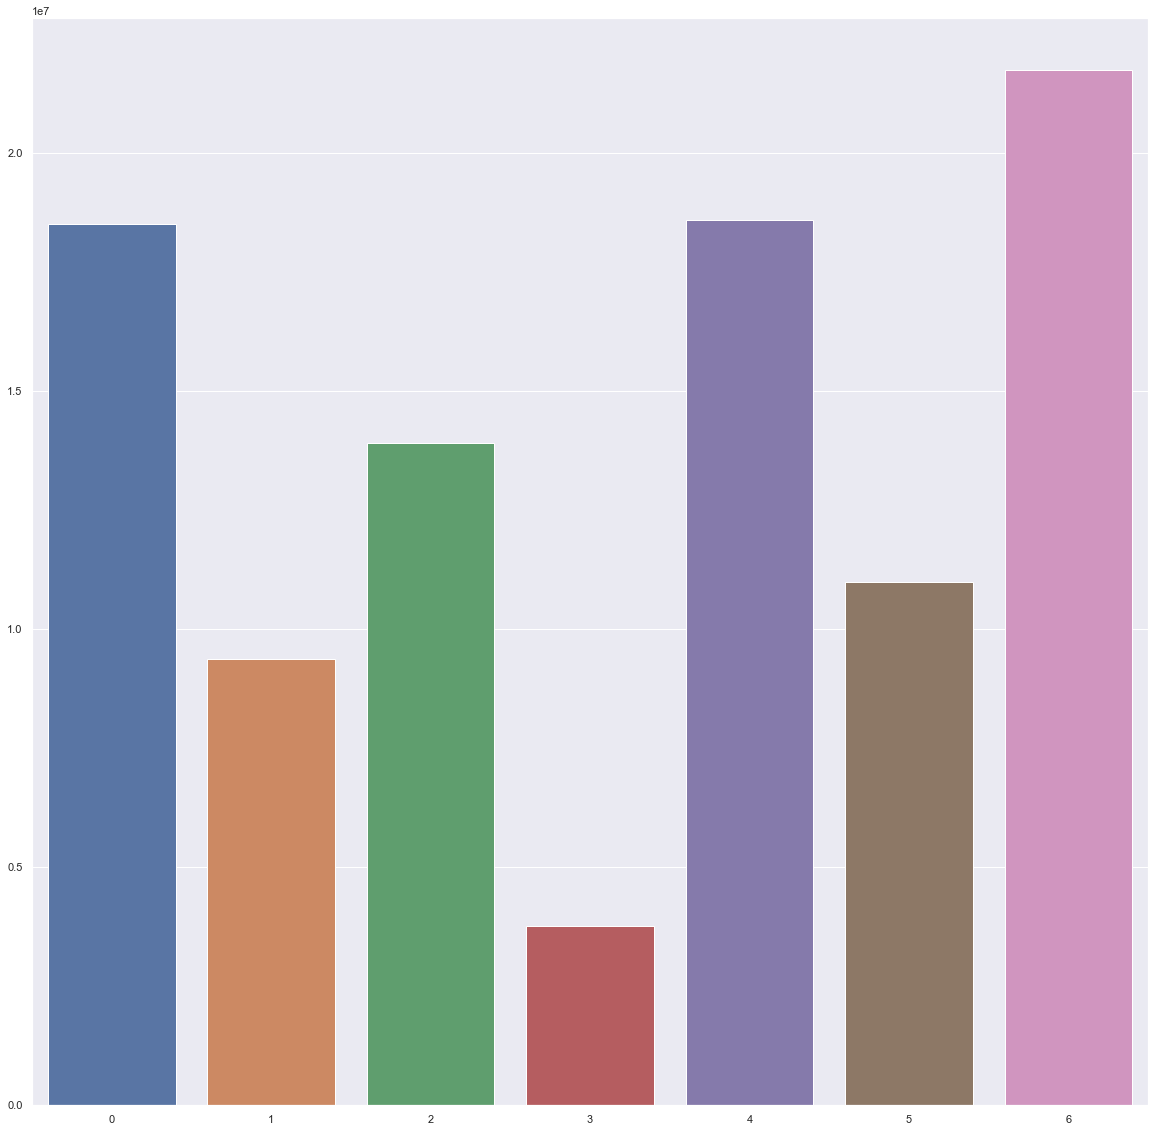

In [34]:
f, axes = plt.subplots(figsize=(20,20))
sb.barplot(x = [0,1,2,3,4,5,6], y = cluster_pop)

[26214.66, 65478.87, 27775.52, 40904.13, 90690.86, 32350.11, 81133.52]


<AxesSubplot:>

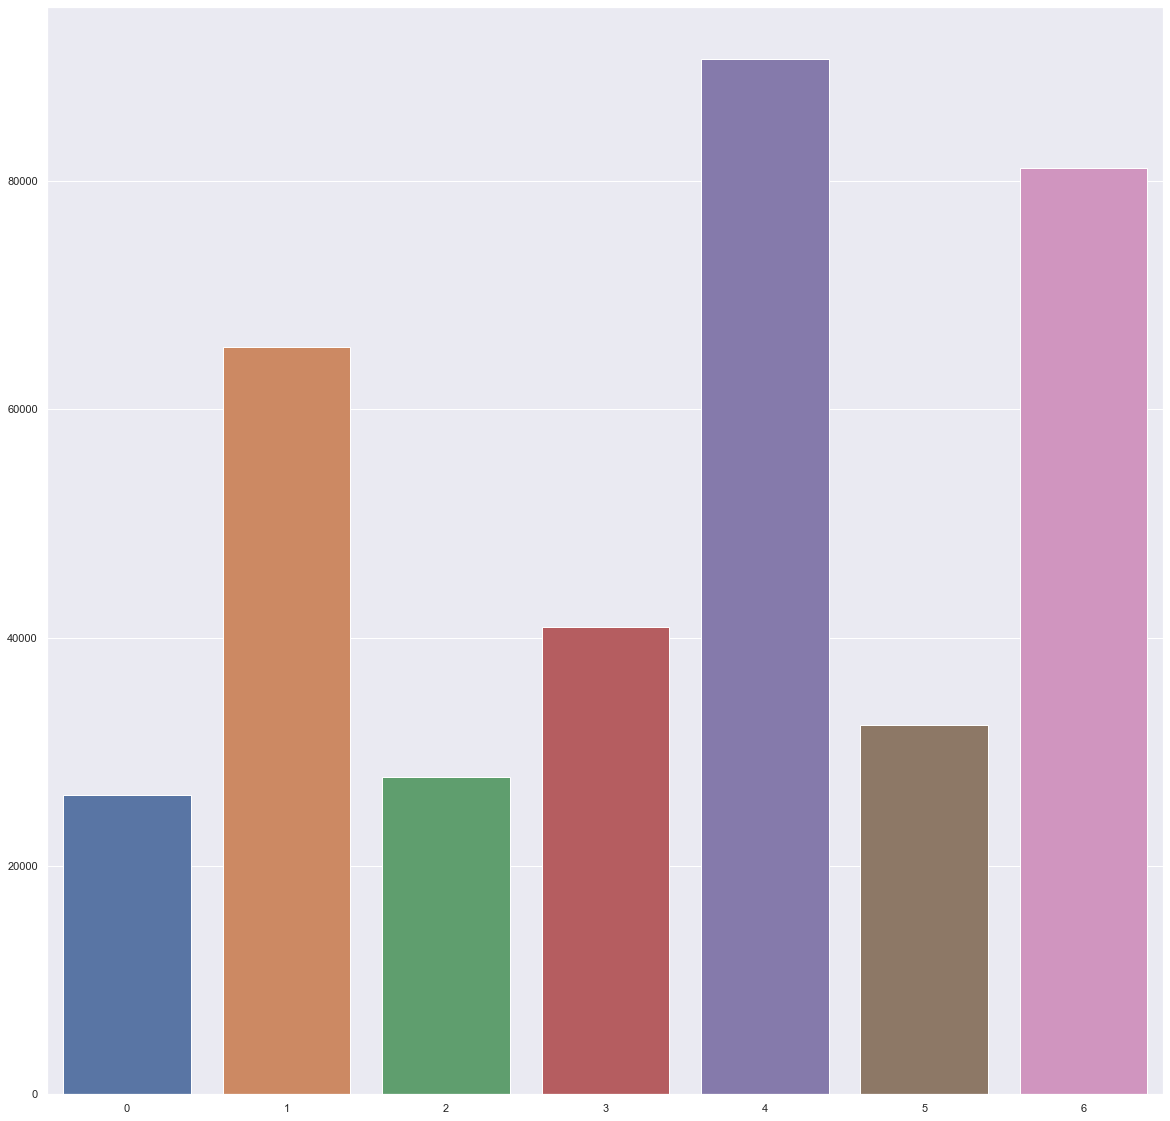

In [35]:
pop_per_shop = [ 0 for i in range(7)]
#print(lst_of_frames)
for cluster in range(7):
    pop_per_shop[cluster] = round(cluster_pop[cluster]/len(lst_of_frames[cluster]),2)

print(pop_per_shop)
f, axes = plt.subplots(figsize=(20,20))
sb.barplot(x = [0,1,2,3,4,5,6], y = pop_per_shop)

In [36]:
#popdf = pd.DataFrame(cluster_pop, columns = ['Total population'])
# popdf = pd.concat([popdf,pd.DataFrame(pop_per_shop, columns = ['Population density'])], axis = 1 )
# popdf = pd.concat([popdf,pd.DataFrame([x for x in range(7)], columns = ['Cluster'])], axis = 1 )
# print(popdf)

# popdf.plot(x = "Cluster", y = ["Total population", "Population density"], kind = "bar")

In [37]:
##Abstracting population data

In [38]:
# import math

# if (isinstance(cities.iloc[0,9],str)):
#     for index in range(len(cities)):
#         cities.iloc[index,9] = math.floor(int(''.join(c for c in (cities.iloc[index,9]) if c.isdigit()))/10)     

In [39]:
# from statistics import median
# cluster_popden = [[] for _ in range(7)]
# print(cluster_popden)
# for index in range(len(cities)):
#     clus = cities.iloc[index,13] 
#     cluster_popden[clus].append(cities.iloc[index,9])
    
# #print(sum([len(cluster_popden[i]) for i in range(7)]))

# #List of dataframes containing city population according to assigned cluster
# dfpopdensity = [pd.DataFrame(cluster_popden[i]) for i in range(7)]
# print(dfpopdensity[0])

In [40]:
# combined = pd.concat(dfpopdensity, axis=1, keys=[i for i in range(7)])

# print(combined.to_string())
# combined = combined.reset_index(level=1)